In [1]:
import sys
import time
import numpy as np
import datetime
import colour
sys.path.append(r'C:\Program Files\Ocean Optics\OceanDirect SDK\Python')
from oceandirect.OceanDirectAPI import OceanDirectAPI, OceanDirectError
import matplotlib.pyplot as plt 



In [2]:
# %% Device Configuration Cell

# Initialize the API.
try:
    api = OceanDirectAPI()
except OceanDirectError as e:
    print("Error initializing OceanDirect API:", e.get_error_details())
    raise

# Discover connected devices.
device_count = api.find_usb_devices()
device_ids = api.get_device_ids()
if device_count == 0 or not device_ids:
    print("No spectrometer connected. Exiting configuration.")
    raise SystemExit

print(f"Total devices found: {device_count}")

# Select your desired device by serial number.
desired_serial = "ST01370"
selected_device = None
for dev_id in device_ids:
    try:
        temp_device = api.open_device(dev_id)
        serial = temp_device.get_serial_number().strip()
        print(f"Found device with ID {dev_id}, Serial: {serial}")
        if serial == desired_serial:
            selected_device = temp_device
            print(f"Selected device: {serial}")
            break
        else:
            api.close_device(dev_id)
    except OceanDirectError as e:
        print(f"Error opening device {dev_id}:", e.get_error_details())

if selected_device is None:
    print(f"No device with serial number {desired_serial} found. Exiting configuration.")
    raise SystemExit

device = selected_device

# Retrieve the current integration time using the get method.
try:
    current_integration_time = device.get_integration_time()
    print("Current Integration Time (µs):", current_integration_time)
except OceanDirectError as e:
    print("Error retrieving integration time:", e.get_error_details())

# Set the boxcar width and scans-to-average.
# These calls override the current settings.
desired_boxcar_width = 1
desired_scans_to_average = 0

try:
    device.set_boxcar_width(desired_boxcar_width)
    print(f"Boxcar width set to {desired_boxcar_width}.")
except OceanDirectError as e:
    print("Error setting boxcar width:", e.get_error_details())

try:
    device.set_scans_to_average(desired_scans_to_average)
    print(f"Scans-to-average set to {desired_scans_to_average}.")
except OceanDirectError as e:
    print("Error setting scans-to-average:", e.get_error_details())

# (Optional) Verify that the new settings have been applied.
try:
    updated_scans_to_average = device.get_scans_to_average()
    updated_boxcar_width = device.get_boxcar_width()
    print("Updated Scans-to-Average:", updated_scans_to_average)
    print("Updated Boxcar Width:", updated_boxcar_width)
except OceanDirectError as e:
    print("Error retrieving updated configuration:", e.get_error_details())




Total devices found: 1
Found device with ID 2, Serial: ST01370
Selected device: ST01370
Current Integration Time (µs): 3910
Boxcar width set to 1.
Scans-to-average set to 0.
Updated Scans-to-Average: 1
Updated Boxcar Width: 1


Retrieved 1516 sensor wavelengths.
Dark spectrum recorded.


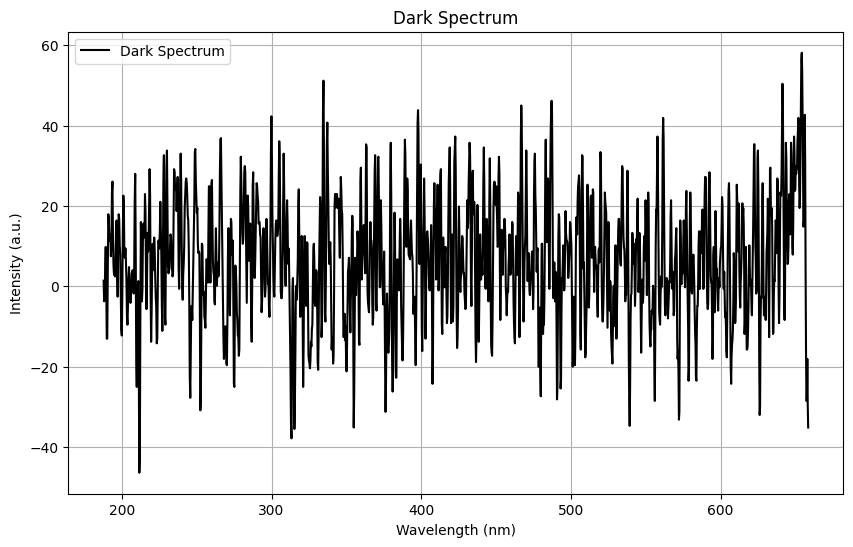

Stored 'dark_spectrum' (ndarray)
Stored 'wavelengths' (ndarray)


In [3]:
# %% Dark Spectrum Measurement Cell
# (Optionally) Retrieve sensor wavelengths.
try:
    wavelengths = np.array(device.get_wavelengths())
    print(f"Retrieved {len(wavelengths)} sensor wavelengths.")
except OceanDirectError as e:
    print("Error retrieving wavelengths:", e.get_error_details())
    wavelengths = np.arange(0, 1516)  # Fallback

# Ensure the device is in DARK condition (no light)
input("Dark Spectrum Measurement: Make sure the spectrometer is completely dark (cover the sensor) and press Enter...")

try:
    dark_spectrum = np.array(device.get_formatted_spectrum())
    print("Dark spectrum recorded.")
except OceanDirectError as e:
    print("Error recording dark spectrum:", e.get_error_details())
    raise SystemExit

# Plot dark spectrum.
plt.figure(figsize=(10,6))
plt.plot(wavelengths, dark_spectrum, label="Dark Spectrum", color="black")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.title("Dark Spectrum")
plt.legend()
plt.grid(True)
plt.show()

# Store the dark spectrum and wavelengths in the notebook session.
%store dark_spectrum
%store wavelengths




Reference spectrum recorded.


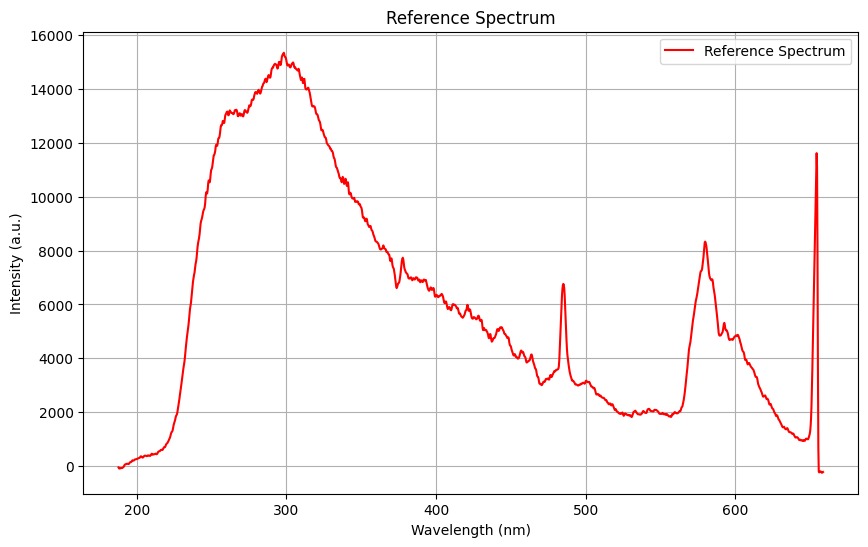

Stored 'reference_spectrum' (ndarray)


In [4]:

# Ensure the device is in REFERENCE condition (white reference under proper illumination).
input("Reference Spectrum Measurement: Place the white reference sample under proper illumination and press Enter...")

try:
    reference_spectrum = np.array(device.get_formatted_spectrum())
    print("Reference spectrum recorded.")
except OceanDirectError as e:
    print("Error recording reference spectrum:", e.get_error_details())
    raise SystemExit

# Plot reference spectrum.
plt.figure(figsize=(10,6))
plt.plot(wavelengths, reference_spectrum, label="Reference Spectrum", color="red")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity (a.u.)")
plt.title("Reference Spectrum")
plt.legend()
plt.grid(True)
plt.show()

# Store the reference spectrum in the notebook session.
%store reference_spectrum


In [ ]:
def load_standard_observer_and_illuminant(sensor_wavelengths):
    from colour import SDS_ILLUMINANTS  # Import the dictionary for spectral distributions.
    cmfs = colour.MSDS_CMFS['CIE 1964 10 Degree Standard Observer']
    illuminant_sd = SDS_ILLUMINANTS['D65']
    x_bar = np.interp(sensor_wavelengths, cmfs.wavelengths, cmfs.values[:, 0])
    y_bar = np.interp(sensor_wavelengths, cmfs.wavelengths, cmfs.values[:, 1])
    z_bar = np.interp(sensor_wavelengths, cmfs.wavelengths, cmfs.values[:, 2])
    illuminant = np.interp(sensor_wavelengths, illuminant_sd.wavelengths, illuminant_sd.values)
    try:
        whitepoint = colour.ILLUMINANTS['CIE 1964 10 Degree Standard Observer']['D65']
    except AttributeError:
        whitepoint = np.array([94.811, 100.000, 107.304])
    return {'x_bar': x_bar, 'y_bar': y_bar, 'z_bar': z_bar}, illuminant, whitepoint

def spectrum_to_xyz(wavelengths, spectrum, cmfs, illuminant):
    # Check if more than 50% of the spectrum has negative values
    negative_percentage = np.sum(spectrum < 0) / len(spectrum) * 100
    
    # If more than 50% of intensity values are negative, convert negatives to zero
    if negative_percentage > 50:
        processed_spectrum = np.clip(spectrum, 0, None)
        print(f"Warning: {negative_percentage:.1f}% of spectrum values were negative - clipping to zero")
    else:
        processed_spectrum = spectrum  # Use original spectrum
    
    # Use np.trapezoid (new name in NumPy 2.0)
    k = 100 / np.trapezoid(illuminant * cmfs['y_bar'], wavelengths)
    X = k * np.trapezoid(processed_spectrum * illuminant * cmfs['x_bar'], wavelengths)
    Y = k * np.trapezoid(processed_spectrum * illuminant * cmfs['y_bar'], wavelengths)
    Z = k * np.trapezoid(processed_spectrum * illuminant * cmfs['z_bar'], wavelengths)
    return np.array([X, Y, Z])


def xyz_to_lab(X, Y, Z, whitepoint):
    """
    Convert from CIE XYZ to CIE Lab.
    """
    # Normalize by whitepoint.
    x = X / whitepoint[0]
    y = Y / whitepoint[1]
    z = Z / whitepoint[2]
    
    # We still need minimal clipping here to ensure valid inputs to f(t) function
    # The f(t) function mathematically requires non-negative inputs
    x = np.maximum(x, 0)  # Alternative to clip that only enforces lower bound
    y = np.maximum(y, 0)
    z = np.maximum(z, 0)
    
    fx = f(x)
    fy = f(y)
    fz = f(z)
    
    L = 116 * fy - 16
    a = 500 * (fx - fy)
    b = 200 * (fy - fz)
    
    return np.array([L, a, b])



def f(t):
    """
    Nonlinear function used in the CIE Lab conversion.
    f(t) = t^(1/3)           if t > (6/29)^3,
         = t/(3*(6/29)^2) + 4/29   otherwise.
    """
    delta = 6/29
    delta_cubed = delta**3
    
    # Ensure t is non-negative before applying power
    t_safe = np.maximum(t, 0)
    
    return np.where(t_safe > delta_cubed, np.power(t_safe, 1/3), t_safe / (3 * (delta**2)) + 4/29)



def xyz_to_lab(X, Y, Z, whitepoint):
    """
    Convert from CIE XYZ to CIE Lab.
    """
    # Normalize by whitepoint.
    x = X / whitepoint[0]
    y = Y / whitepoint[1]
    z = Z / whitepoint[2]
   
   
    fx = f(x)
    fy = f(y)
    fz = f(z)
   
    L = 116 * fy - 16
    a = 500 * (fx - fy)
    b = 200 * (fy - fz)
   
    return np.array([L, a, b])


# Load colorimetric data.
cmfs, illuminant, whitepoint = load_standard_observer_and_illuminant(wavelengths)


# Determine indices corresponding to 270 nm and 320 nm.
idx_min = np.where(wavelengths >= 270)[0][0]
idx_max = np.where(wavelengths <= 300)[0][-1]


# Set the integrated intensity trigger threshold.
trigger_threshold = 20


print("Starting continuous measurement loop (integration over 270-320 nm).")
print("Trigger output only if integrated intensity is below", trigger_threshold)
print("Press Ctrl+C to exit.")


try:
    while True:
        raw_spectrum = np.array(device.get_formatted_spectrum())
       
        # Apply calibration correction: (Raw - Dark) / ((Reference - Dark) + eps)
        eps = 1e-6
        corrected = (raw_spectrum - dark_spectrum) / ((reference_spectrum - dark_spectrum) + eps)
       
        # Integrate the corrected spectrum only between 270 nm and 320 nm using np.trapezoid.
        integrated_intensity = np.trapezoid(corrected[idx_min:idx_max+1], wavelengths[idx_min:idx_max+1])
       
        # If the integrated intensity is less than the trigger threshold, then sample absorption is significant.
        if integrated_intensity < trigger_threshold:
            xyz = spectrum_to_xyz(wavelengths, corrected, cmfs, illuminant)
            # Unpack the xyz array into X, Y, Z before converting.
            lab = xyz_to_lab(xyz[0], xyz[1], xyz[2], whitepoint)
            print(f"Sample detected. Integrated intensity = {integrated_intensity:.2f}")
            print("Measured CIE XYZ:", xyz)
            print("Measured CIE LAB:", lab)
        else:
            print(f"No sample detected. Integrated intensity = {integrated_intensity:.2f}")
       
        time.sleep(10)


       
except KeyboardInterrupt:
    print("\nMeasurement loop interrupted by user.")


# Close the device.
try:
    api.close_device(device.get_device_id())
    print("Device closed successfully.")
except Exception as e:
    print("Error closing device:", e)







Starting continuous measurement loop (integration over 270-320 nm).
Trigger output only if integrated intensity is below 50
Press Ctrl+C to exit.
Sample detected. Integrated intensity = 29.76
Measured CIE XYZ: [  94.5542391   100.91709462  108.6406428 ]
Measured CIE LAB: [ 100.35353138   -1.97560587   -0.21747853]
Sample detected. Integrated intensity = 29.65
Measured CIE XYZ: [  92.57926032   98.82298613  106.68168879]
Measured CIE LAB: [ 99.54309062  -1.98489178  -0.40039057]
Sample detected. Integrated intensity = 29.70
Measured CIE XYZ: [  92.90018064   99.08109346  107.22800854]
Measured CIE LAB: [ 99.64359556  -1.8455931   -0.5672667 ]
Sample detected. Integrated intensity = -0.37
Measured CIE XYZ: [ 88.98546169  96.46977918  83.58192718]
Measured CIE LAB: [ 98.61859592  -4.50349531  13.59948675]


C:\Users\SSB-2\AppData\Local\Temp\ipykernel_9704\1413162095.py:69: RuntimeWarning: invalid value encountered in power
  return np.where(t > delta_cubed, np.power(t, 1/3), t / (3 * (delta**2)) + 4/29)


Sample detected. Integrated intensity = -0.39
Measured CIE XYZ: [ 62.53942315  49.09490551  -1.69731704]
Measured CIE LAB: [  75.51033223   40.80517711  154.82504245]
Sample detected. Integrated intensity = 29.70
Measured CIE XYZ: [  92.55907296   98.62957922  106.6733634 ]
Measured CIE LAB: [ 99.46766476  -1.69583798  -0.52524247]
Sample detected. Integrated intensity = -0.32
Measured CIE XYZ: [ 90.58475776  97.60290976  91.50483351]
Measured CIE LAB: [ 99.06561887  -3.51494032   8.73032681]
Sample detected. Integrated intensity = -0.34
Measured CIE XYZ: [ 71.60838527  72.51208861  17.47366268]
Measured CIE LAB: [ 88.21449477   6.14230244  70.46422851]
Sample detected. Integrated intensity = -0.36
Measured CIE XYZ: [ 71.41011699  72.21943796  17.4103147 ]
Measured CIE LAB: [ 88.0741064    6.32678745  70.35432107]
Sample detected. Integrated intensity = -0.36
Measured CIE XYZ: [ 90.15891873  97.99857927  88.47513694]
Measured CIE LAB: [ 99.22089625  -4.95713293  11.11476237]
Sample det